필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [4]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [5]:
jsb_yearly = pd.read_excel(base_path+"Jugsanbo.xlsx", 
# jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [6]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [7]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [8]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [9]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [10]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [11]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [12]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [13]:
jsb_flow_yearly = pd.read_excel(base_path+"Jugsanbo_flow.xlsx", 
# jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [14]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [15]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [16]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [17]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [18]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [19]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [20]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [21]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [22]:
jsb_data = jsb_data[:82064]

In [23]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [24]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [25]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [26]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [27]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [28]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [29]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [30]:
len(jsb_data)

82064

시간데이터 추가

In [31]:
jsb_df = jsb_data.copy()

In [32]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [33]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [34]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [35]:
for var in col_c[2:]:
    for i in range(1, 49):
        jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)

/tmp/ipykernel_3049/3950707837.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  jsb_df[str(i) + 'shift' + var] = jsb_df[var].shift(i)


In [36]:
len(jsb_df)

82064

In [37]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)',
       ...
       '39shift방류량(㎥/s)', '40shift방류량(㎥/s)', '41shift방류량(㎥/s)',
       '42shift방류량(㎥/s)', '43shift방류량(㎥/s)', '44shift방류량(㎥/s)',
       '45shift방류량(㎥/s)', '46shift방류량(㎥/s)', '47shift방류량(㎥/s)',
       '48shift방류량(㎥/s)'],
      dtype='object', length=395)

In [38]:
len(jsb_df)

82064

결측치 보간법

In [39]:
from datetime import datetime

In [40]:
jsb_df = jsb_df.copy()

In [41]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [42]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [43]:
jsb_df = jsb_df.dropna()

In [44]:
jsb_df.__len__()

79915

In [45]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       ...
       '39shift방류량(㎥/s)', '40shift방류량(㎥/s)', '41shift방류량(㎥/s)',
       '42shift방류량(㎥/s)', '43shift방류량(㎥/s)', '44shift방류량(㎥/s)',
       '45shift방류량(㎥/s)', '46shift방류량(㎥/s)', '47shift방류량(㎥/s)',
       '48shift방류량(㎥/s)'],
      dtype='object', length=394)

In [46]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '1shift전기전도도 μS/cm', '2shift전기전도도 μS/cm', '3shift전기전도도 μS/cm', '4shift전기전도도 μS/cm', '5shift전기전도도 μS/cm', '6shift전기전도도 μS/cm', '7shift전기전도도 μS/cm', '8shift전기전도도 μS/cm', '9shift전기전도도 μS/c

In [47]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift수온 ℃', '2shift수온 ℃', '3shift수온 ℃', '4shift수온 ℃', '5shift수온 ℃', '6shift수온 ℃', '7shift수온 ℃', '8shift수온 ℃', '9shift수온 ℃', '10shift수온 ℃', '11shift수온 ℃', '12shift수온 ℃', '13shift수온 ℃', '14shift수온 ℃', '15shift수온 ℃', '16shift수온 ℃', '17shift수온 ℃', '18shift수온 ℃', '19shift수온 ℃', '20shift수온 ℃', '21shift수온 ℃', '22shift수온 ℃', '23shift수온 ℃', '24shift수온 ℃', '25shift수온 ℃', '26shift수온 ℃', '27shift수온 ℃', '28shift수온 ℃', '29shift수온 ℃', '30shift수온 ℃', '31shift수온 ℃', '32shift수온 ℃', '33shift수온 ℃', '34shift수온 ℃', '35shift수온 ℃', '36shift수온 ℃', '37shift수온 ℃', '38shift수온 ℃', '39shift수온 ℃', '40shift수온 ℃', '41shift수온 ℃', '42shift수온 ℃', '43shift수온 ℃', '44shift수온 ℃', '45shift수온 ℃', '46shift수온 ℃', '47shift수온 ℃', '48shift수온 ℃', '1shift전기전도도 μS/cm', '2shift전기전도도 μS/cm', '3shift전기전도도 μS/cm', '4shift전기전도도 μS/cm', '5shift전기전도도 μS/cm', '6shift전기전도도 μS/cm', '7shift전기전도도 μS/cm', '8shift전기전도도 μS/cm', '9shift전기전도도 μS/cm', '10shift전기전

피처 정규화 없이

In [48]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [49]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [50]:
gb_grid.fit(X_train, np.log1p(y_train))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.747 total time= 9.3min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.739 total time= 9.3min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.737 total time= 9.2min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.946 total time=18.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.946 total time=18.2min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.944 total time=18.2min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=25.9min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.960 total time=25.8min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.960 total time=26.0min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.812 total time= 9.3min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.801 total time= 9.3min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [51]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [52]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.961046,1
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.961029,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.957207,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.956227,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.955974,5


In [53]:
gb_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 15}

In [54]:
estimator = gb_grid.best_estimator_

In [55]:
pred = estimator.predict(X_test)

In [56]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.01 전기전도도 μS/cm
0.1 탁도 NTU
0.11 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.02 상류수위(EL.m)
0.0 방류량(㎥/s)
0.02 1shift수온 ℃
0.0 2shift수온 ℃
0.0 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.0 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.0 32shift수온 ℃
0.01 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.01 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.01 43shift수온 ℃
0.01 44shift수온 ℃
0.0 45shift수온 ℃
0.01 46shift수온 ℃
0.0 47shift수온 ℃
0.15 48shift수온 ℃
0.01 1shift전기전도도 μS/cm
0.0 2shift전기전도도 μS/cm
0.0 3shift전기전도도 μS/cm
0.0 4shift전기전도도 μS/cm
0.0 5shift전기전도도 μS/cm
0.0 6shift전기전도도 μS/cm
0

/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: 

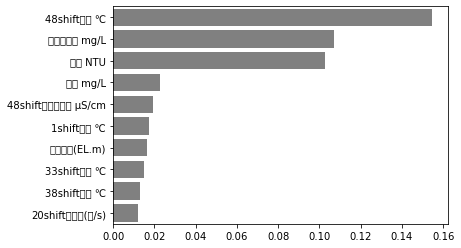

In [57]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [58]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9742779674057184


In [59]:
feature_series[:10]

48shift수온 ℃           0.154569
총유기탄소 mg/L            0.107062
탁도 NTU                0.102870
총인 mg/L               0.022938
48shift전기전도도 μS/cm    0.019304
1shift수온 ℃            0.017328
상류수위(EL.m)            0.016301
33shift수온 ℃           0.014879
38shift수온 ℃           0.013138
20shift방류량(㎥/s)       0.012075
dtype: float64

피처 정규화

In [60]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [61]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift수온 ℃,2shift수온 ℃,3shift수온 ℃,...,39shift방류량(㎥/s),40shift방류량(㎥/s),41shift방류량(㎥/s),42shift방류량(㎥/s),43shift방류량(㎥/s),44shift방류량(㎥/s),45shift방류량(㎥/s),46shift방류량(㎥/s),47shift방류량(㎥/s),48shift방류량(㎥/s)
0,-1.199211,-0.203693,-0.556513,-0.368312,1.557556,1.019431,-0.178349,-0.672491,-0.684551,-0.696599,...,-0.277834,-0.277833,-0.277831,-0.277829,-0.277828,-0.277826,-0.277824,-0.277823,-0.277821,-0.277819
1,-1.188071,-0.191859,-0.556513,-0.432372,1.537334,1.030206,-0.165746,-0.660425,-0.672485,-0.684532,...,-0.277834,-0.277833,-0.277831,-0.277829,-0.277828,-0.277826,-0.277824,-0.277823,-0.277821,-0.277819
2,-1.176931,-0.197776,-0.556513,-0.487279,1.537334,1.032900,-0.162187,-0.636292,-0.660418,-0.672466,...,-0.277834,-0.277833,-0.277831,-0.277829,-0.277828,-0.277826,-0.277824,-0.277823,-0.277821,-0.277819
3,-1.176931,-0.197776,-0.556513,-0.437862,1.577778,1.032900,-0.162187,-0.624225,-0.636285,-0.660399,...,-0.277834,-0.277833,-0.277831,-0.277829,-0.277828,-0.277826,-0.277824,-0.277823,-0.277821,-0.277819
4,-1.176931,-0.197776,-0.556513,-0.412849,1.577778,1.032900,-0.162187,-0.624225,-0.624219,-0.636266,...,-0.277834,-0.277833,-0.277831,-0.277829,-0.277828,-0.277826,-0.277824,-0.277823,-0.277821,-0.277819


In [62]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [63]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3, verbose=5)

In [64]:
gb_grids.fit(X_trains, np.log1p(y_trains))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.747 total time= 9.3min
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.739 total time= 9.3min
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.737 total time= 9.3min
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.946 total time=18.2min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.946 total time=18.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.945 total time=18.4min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.963 total time=25.8min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.959 total time=25.9min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.960 total time=26.0min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.812 total time= 9.3min
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.801 total time= 9.3min
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [65]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [66]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.961180,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.961111,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.957407,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.956083,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.955959,5


In [67]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [68]:
estimators = gb_grids.best_estimator_

In [69]:
preds = estimators.predict(X_tests)

In [70]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.01 전기전도도 μS/cm
0.1 탁도 NTU
0.11 총유기탄소 mg/L
0.01 총질소 mg/L
0.02 총인 mg/L
0.02 상류수위(EL.m)
0.0 방류량(㎥/s)
0.02 1shift수온 ℃
0.0 2shift수온 ℃
0.0 3shift수온 ℃
0.0 4shift수온 ℃
0.0 5shift수온 ℃
0.0 6shift수온 ℃
0.0 7shift수온 ℃
0.0 8shift수온 ℃
0.0 9shift수온 ℃
0.0 10shift수온 ℃
0.0 11shift수온 ℃
0.0 12shift수온 ℃
0.0 13shift수온 ℃
0.0 14shift수온 ℃
0.0 15shift수온 ℃
0.0 16shift수온 ℃
0.0 17shift수온 ℃
0.0 18shift수온 ℃
0.0 19shift수온 ℃
0.0 20shift수온 ℃
0.0 21shift수온 ℃
0.0 22shift수온 ℃
0.0 23shift수온 ℃
0.0 24shift수온 ℃
0.0 25shift수온 ℃
0.0 26shift수온 ℃
0.0 27shift수온 ℃
0.0 28shift수온 ℃
0.0 29shift수온 ℃
0.0 30shift수온 ℃
0.0 31shift수온 ℃
0.0 32shift수온 ℃
0.02 33shift수온 ℃
0.0 34shift수온 ℃
0.0 35shift수온 ℃
0.0 36shift수온 ℃
0.0 37shift수온 ℃
0.01 38shift수온 ℃
0.0 39shift수온 ℃
0.0 40shift수온 ℃
0.0 41shift수온 ℃
0.0 42shift수온 ℃
0.01 43shift수온 ℃
0.01 44shift수온 ℃
0.0 45shift수온 ℃
0.01 46shift수온 ℃
0.0 47shift수온 ℃
0.15 48shift수온 ℃
0.0 1shift전기전도도 μS/cm
0.0 2shift전기전도도 μS/cm
0.0 3shift전기전도도 μS/cm
0.0 4shift전기전도도 μS/cm
0.0 5shift전기전도도 μS/cm
0.0 6shift전기전도도 μS/cm
0.

/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/gslee/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: 

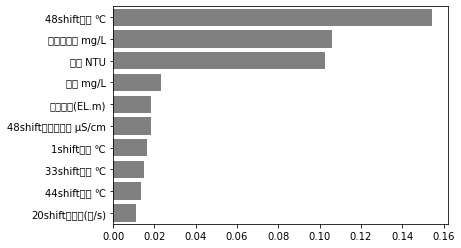

In [71]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [72]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.97534875670348


In [73]:
feature_series[:10]

48shift수온 ℃           0.154569
총유기탄소 mg/L            0.107062
탁도 NTU                0.102870
총인 mg/L               0.022938
48shift전기전도도 μS/cm    0.019304
1shift수온 ℃            0.017328
상류수위(EL.m)            0.016301
33shift수온 ℃           0.014879
38shift수온 ℃           0.013138
20shift방류량(㎥/s)       0.012075
dtype: float64